In sbcana.F90 (under MY_SRC):
        utau(ji,jj) = - ztaun * SIN( rpi * (gphiu(ji,jj) - 15.) / (55.-15.) )
        vtau(ji,jj) =   ztaun * SIN( rpi * (gphiv(ji,jj) - 15.) / (55.-15.) )


## Import modules and tools

In [1]:
import sys
sys.path.insert(0, '_libs/')

In [2]:
from __future__ import division, print_function

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.image as mpimg
import netCDF4 as nc
import NEMO_tools as Nts
import numpy as np
import scipy.io as sio
import pandas as pd


from salishsea_tools import nc_tools
from salishsea_tools import viz_tools
from matplotlib.pyplot import *

from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.basemap import Basemap

%matplotlib inline


In [3]:
reload(Nts)

NameError: name 'reload' is not defined

## Read NEMO_GYRE output data files

In [4]:
gridU = nc.Dataset('/ocean/mgrenier/geotraces/MyGyre/4e-GYRE_LabSea_WindChanges/GYRE_5d_00010101_00011230_grid_U.nc')
gridV = nc.Dataset('/ocean/mgrenier/geotraces/MyGyre/4e-GYRE_LabSea_WindChanges/GYRE_5d_00010101_00011230_grid_V.nc')
gridW = nc.Dataset('/ocean/mgrenier/geotraces/MyGyre/4e-GYRE_LabSea_WindChanges/GYRE_5d_00010101_00011230_grid_W.nc')
gridT = nc.Dataset('/ocean/mgrenier/geotraces/MyGyre/4e-GYRE_LabSea_WindChanges/GYRE_5d_00010101_00011230_grid_T.nc')

In [5]:
#nc_tools.show_dimensions(gridT)
#nc_tools.show_dataset_attrs(gridT)
#nc_tools.show_variable_attrs(gridT)

## Read *.nc files & calculate annual mean value

In [6]:
lon = gridT.variables['nav_lon'][:]
lat = gridT.variables['nav_lat'][:]
U = gridU.variables['vozocrtx'][:]
V = gridV.variables['vomecrty'][:]
W = gridW.variables['vovecrtz'][:]
sal = gridT.variables['vosaline'][:]
temp = gridT.variables['votemper'][:]
sst = gridT.variables['sosstsst'][:]
print(lon.shape,lat.shape,sal.shape)

(32, 22) (32, 22) (72, 31, 32, 22)


In [7]:
# annual mean: do an average over the 72 timestep
tempMean=np.mean(temp, axis=0)
sstMean=np.mean(sst, axis=0)
salMean=np.mean(sal, axis=0)
u_NE=np.mean(U, axis=0)
v_NW=np.mean(V, axis=0)
WMean=np.mean(W, axis=0)
print(salMean.shape)
print('Annual mean data size: {}'.format(tempMean.shape))
# correct the velocity <--------------------------------- ?
UMean=np.sqrt(1/2)*(u_NE-v_NW)
VMean=np.sqrt(1/2)*(u_NE+v_NW)

(31, 32, 22)
Annual mean data size: (31, 32, 22)


## GYRE model grid

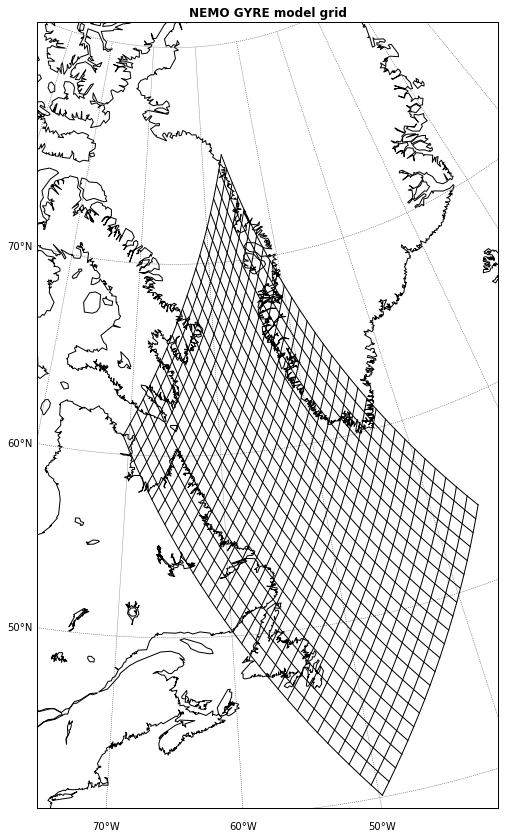

In [8]:
latlim=[40, 75]
lonlim=[-75, 0]
fig=plt.figure(figsize=(8, 16))
ax=fig.add_axes([0.1, 0.1, 0.8, 0.8])
proj=Basemap(projection='lcc',\
            lat_1=30, lat_2=60, lat_0=45, lon_0=-65,\
            llcrnrlon=lonlim[0], llcrnrlat=latlim[0],\
            urcrnrlon=lonlim[1], urcrnrlat=latlim[1],\
            resolution='l')
# draw coast line
proj.drawcoastlines(linewidth=1, color='k') #map.drawcountries, map.drawstates, map.fillcontinents
# draw parallels.
parallels = np.arange(-90, 91, 10)
proj.drawparallels(parallels, labels=[1, 0, 0, 0], color = '0.25',linewidth= 0.5, fontsize=10)
# draw meridians
meridians = np.arange(-180, 180, 10)
proj.drawmeridians(meridians, labels=[0, 0, 0, 1], color = '0.25',linewidth= 0.5, fontsize=10)
# transfer from Lat/Lon to projected grid
x, y=proj(lon, lat) 
proj.plot(x, y, color='k', linewidth=1)
proj.plot(x.T, y.T, color='k', linewidth=1)
ax.set_title('NEMO GYRE model grid', fontsize=12, fontweight='bold')
plt.show()


## Get time-averaged data & mask data

In [9]:
# delete horizontal 4 edges 
#(the bottom will be deleted in section 4)
# =================================== #
# sst
sst=Nts.delete_edge(sst, [1, 1, 1, 1])
# vot
for i in range(np.size(tempMean, 0)):
    tpry=tempMean[i, :, :]
    tpry=Nts.delete_edge(tpry, [1, 1, 1, 1])
    tempMean[i, :, :]=tpry
# u
for i in range(np.size(UMean, 0)):
    tpry=UMean[i, :, :]
    tpry=Nts.delete_edge(tpry, [1, 1, 2, 2])
    UMean[i, :, :]=tpry
# v
for i in range(np.size(VMean, 0)):
    tpry=VMean[i, :, :]
    tpry=Nts.delete_edge(tpry, [1, 1, 2, 2])
    VMean[i, :, :]=tpry
# w
for i in range(np.size(WMean, 0)):
    tpry=WMean[i, :, :]
    tpry=Nts.delete_edge(tpry, [1, 1, 2, 2])
    WMean[i, :, :]=tpry
# =================================== #
# get valuable, and mask for surface plot
# sst
sst_ma=np.ma.masked_where(np.isnan(sst), sst)
# surface current
u_surface=UMean[0, :, :]
v_surface=VMean[0, :, :]
u_s_ma=np.ma.masked_where(np.isnan(u_surface), u_surface)
v_s_ma=np.ma.masked_where(np.isnan(v_surface), v_surface)
# 210 m depth
u_200=UMean[11, :, :]
v_200=VMean[11, :, :]
u_200_ma=np.ma.masked_where(np.isnan(u_200), u_200)
v_200_ma=np.ma.masked_where(np.isnan(v_200), v_200)
# 550 m depth
u_500=UMean[15, :, :]
v_500=VMean[15, :, :]
u_500_ma=np.ma.masked_where(np.isnan(u_500), u_500)
v_500_ma=np.ma.masked_where(np.isnan(v_500), v_500)
# 1080 m depth
u_1000=UMean[18, :, :]
v_1000=VMean[18, :, :]
u_1000_ma=np.ma.masked_where(np.isnan(u_1000), u_1000)
v_1000_ma=np.ma.masked_where(np.isnan(v_1000), v_1000)
# 2090 m depth
u_2000=UMean[22, :, :]
v_2000=VMean[22, :, :]
u_2000_ma=np.ma.masked_where(np.isnan(u_2000), u_2000)
v_2000_ma=np.ma.masked_where(np.isnan(v_2000), v_2000)
# 2950 m depth
u_3000=UMean[25, :, :]
v_3000=VMean[25, :, :]
u_3000_ma=np.ma.masked_where(np.isnan(u_3000), u_3000)
v_3000_ma=np.ma.masked_where(np.isnan(v_3000), v_3000)
# 3850 m depth
u_4000=UMean[28, :, :]
v_4000=VMean[28, :, :]
u_4000_ma=np.ma.masked_where(np.isnan(u_4000), u_4000)
v_4000_ma=np.ma.masked_where(np.isnan(v_4000), v_4000)


## Sea surface currents

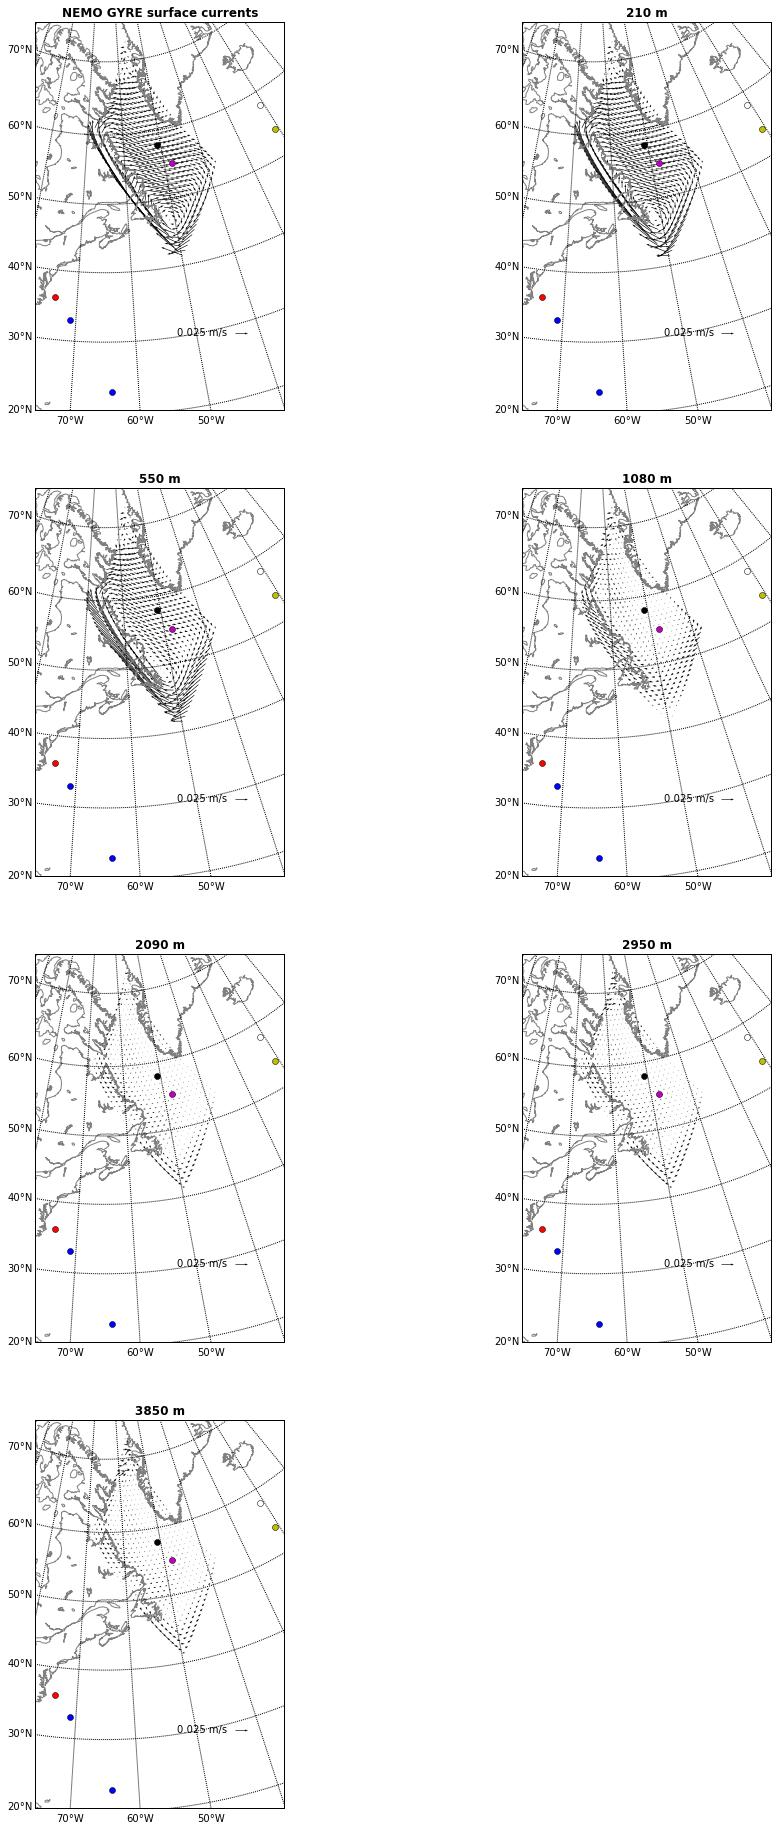

In [10]:
# Common
latlim=[20, 65]
lonlim=[-75, 0]
#speed=np.sqrt(u_s_ma*u_s_ma+v_s_ma*v_s_ma)
# Figure
fig,((ax1,ax2),(ax3,ax4),(ax5,ax6),(ax7,ax8))=plt.subplots(4,2,figsize=(16, 32))
#ax=fig.add_axes([0.1, 0.1, 0.8, 0.8])
for axX,u_XX_ma,v_XX_ma,name in zip((ax1,ax2,ax3,ax4,ax5,ax6,ax7),
                                                   (u_s_ma,u_200_ma,u_500_ma,u_1000_ma,u_2000_ma,u_3000_ma,u_4000_ma),
                                                   (v_s_ma,v_200_ma,v_500_ma,v_1000_ma,v_2000_ma,v_3000_ma,v_4000_ma),
                                                   ('NEMO GYRE surface currents','210 m','550 m','1080 m','2090 m','2950 m','3850 m')):
    
    proj=Basemap(projection='lcc',\
                lat_1=30, lat_2=60, lat_0=45, lon_0=-65,\
                llcrnrlon=lonlim[0], llcrnrlat=latlim[0],\
                urcrnrlon=lonlim[1], urcrnrlat=latlim[1],\
                resolution='l',ax=axX)
    # draw coast line
    proj.drawcoastlines(linewidth=1, color=[0.5, 0.5, 0.5]) #map.drawcountries, map.drawstates, map.fillcontinents
    # draw parallels.
    parallels = np.arange(0, 90, 10)
    proj.drawparallels(parallels, labels=[1, 0, 0, 0],fontsize=10)
    # draw meridians
    meridians = np.arange(180, 360, 10)
    proj.drawmeridians(meridians, labels=[0, 0, 0, 1],fontsize=10)
    # transform lat/lon to projection grid.
    x, y=proj(lon, lat)
    # streamline
    Q=proj.quiver(x, y, u_XX_ma, v_XX_ma, width=0.0025, scale=0.025/0.05)
    # make quiver key.
    Qlabel=axX.quiverkey(Q, 0.8, 0.2, 0.025, '0.025 m/s', labelpos='W') # width, height, scale, label, position
    #width=5*speed/speed.max() # '5' is the scale
    #map.streamplot(x, y, u_s_ma, v_s_ma, density=0.6, color='k', linewidth=width)
    # add 230Th (diss & partic) station location
    for lonTh, latTh, styl in zip((-74,-71,-64,-20,-19,-21,-48,-20,-21,-45,-51),
                                  (36,33,23,48,47,54,55,48,58,8,58),
                                  ('or','ob','ob','ok','og','oy','om','ow','ow','oc','ok')):
        xTh, yTh = proj(lonTh, latTh)
        ThSta = axX.plot(xTh, yTh,styl)
    # title
    axX.set_title(name, fontsize=12, fontweight='bold')

fig.delaxes(ax8)
#plt.show()



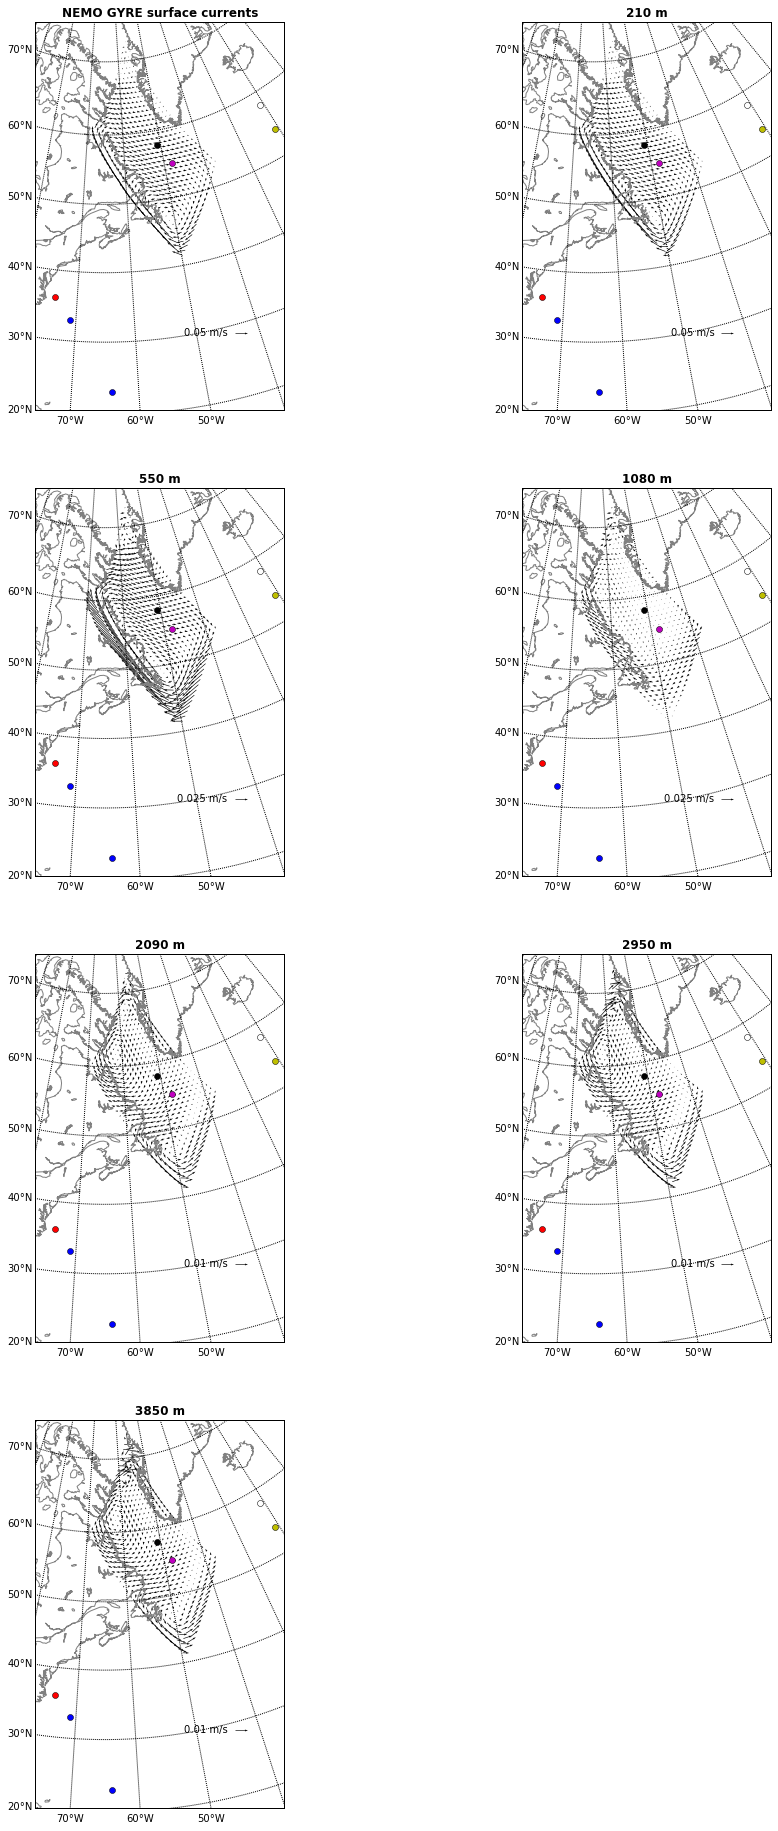

In [11]:
# Common
latlim=[20, 65]
lonlim=[-75, 0]
#speed=np.sqrt(u_s_ma*u_s_ma+v_s_ma*v_s_ma)
# Figure
fig,((ax1,ax2),(ax3,ax4),(ax5,ax6),(ax7,ax8))=plt.subplots(4,2,figsize=(16, 32))
#ax=fig.add_axes([0.1, 0.1, 0.8, 0.8])
for axX,u_XX_ma,v_XX_ma,scale,scaleLab,name in zip((ax1,ax2,ax3,ax4,ax5,ax6,ax7),
                                                   (u_s_ma,u_200_ma,u_500_ma,u_1000_ma,u_2000_ma,u_3000_ma,u_4000_ma),
                                                   (v_s_ma,v_200_ma,v_500_ma,v_1000_ma,v_2000_ma,v_3000_ma,v_4000_ma),
                                                   (0.05,0.05,0.025,0.025,0.01,0.01,0.01),
                                                   ('0.05 m/s','0.05 m/s','0.025 m/s','0.025 m/s','0.01 m/s','0.01 m/s','0.01 m/s'),
                                                   ('NEMO GYRE surface currents','210 m','550 m','1080 m','2090 m','2950 m','3850 m')):
    
    proj=Basemap(projection='lcc',\
                lat_1=30, lat_2=60, lat_0=45, lon_0=-65,\
                llcrnrlon=lonlim[0], llcrnrlat=latlim[0],\
                urcrnrlon=lonlim[1], urcrnrlat=latlim[1],\
                resolution='l',ax=axX)
    # draw coast line
    proj.drawcoastlines(linewidth=1, color=[0.5, 0.5, 0.5]) #map.drawcountries, map.drawstates, map.fillcontinents
    # draw parallels.
    parallels = np.arange(0, 90, 10)
    proj.drawparallels(parallels, labels=[1, 0, 0, 0],fontsize=10)
    # draw meridians
    meridians = np.arange(180, 360, 10)
    proj.drawmeridians(meridians, labels=[0, 0, 0, 1],fontsize=10)
    # transform lat/lon to projection grid.
    x, y=proj(lon, lat)
    # streamline
    Q=proj.quiver(x, y, u_XX_ma, v_XX_ma, width=0.0025, scale=scale/0.05)
    # make quiver key.
    Qlabel=axX.quiverkey(Q, 0.8, 0.2, scale, scaleLab, labelpos='W') # width, height, scale, label, position
    #width=5*speed/speed.max() # '5' is the scale
    #map.streamplot(x, y, u_s_ma, v_s_ma, density=0.6, color='k', linewidth=width)
    # add 230Th (diss & partic) station location
    for lonTh, latTh, styl in zip((-74,-71,-64,-20,-19,-21,-48,-20,-21,-45,-51),
                                  (36,33,23,48,47,54,55,48,58,8,58),
                                  ('or','ob','ob','ok','og','oy','om','ow','ow','oc','ok')):
        xTh, yTh = proj(lonTh, latTh)
        ThSta = axX.plot(xTh, yTh,styl)
    # title
    axX.set_title(name, fontsize=12, fontweight='bold')

fig.delaxes(ax8)
#plt.show()

